In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV, validation_curve 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.kernel_approximation import RBFSampler
from pprint import pprint


In [3]:
#read in and check data
df=pd.read_pickle('working_data.pkl')
df.head()


,male,age,hypertension,heart_disease,ever_married,work_type,urban_resident,avg_glucose_level,bmi,has_smoked,stroke,bmi_class,glucose_class,risk_factor
id,,,,,,,,,,,,,,
30468,1,58.0,1,0,1,Private,1,87.96,39.2,0,0,Obese,41st-60th,One
56543,0,70.0,0,0,1,Private,0,69.04,35.9,0,0,Obese,0-20th,Neither
52800,0,52.0,0,0,1,Private,1,77.59,17.7,0,0,Underweight,21st-40th,Neither
41413,0,75.0,0,1,1,Self-employed,0,243.53,27.0,0,0,Overweight,81st-100th,One
15266,0,32.0,0,0,1,Private,0,77.67,32.3,1,0,Obese,21st-40th,Neither


In [4]:
#create feature array X
X=df.loc[:,'male':'has_smoked']
X=X.drop(['work_type'], axis =1)

X=np.array(X.values)
#create target array y
y=np.array(df.stroke.values)
#y=y.reshape(-1,1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, random_state=5)

In [92]:
#run basic logistic regression model
lr= LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(Xtrain,ytrain)
print('Accuracy {}'.format(accuracy_score(lr.predict(Xtest), ytest)))
print('Confusion Matix {}'.format(confusion_matrix(lr.predict(Xtest), ytest)))

Accuracy 0.978408754806
Confusion Matix [[6616  146]
 [   0    0]]


In [93]:
#Tune logstic regression model us GridSearch
cs = [0.001, 0.1, 1, 10, 100]
maxiter= [1000,2000,3000]
C= {'C':cs, 'max_iter':maxiter}
lr= LogisticRegression(solver='lbfgs')
gs= GridSearchCV(lr, C, cv=5)
gs=gs.fit(Xtrain, ytrain)
print("Tuned Logistic Regression Parameters: {}".format(gs.best_params_)) 
print(accuracy_score(gs.predict(Xtest), ytest))
print("Best score is: {}".format(gs.best_score_))
print(confusion_matrix(gs.predict(Xtest), ytest))



Tuned Logistic Regression Parameters: {'C': 0.001, 'max_iter': 1000}
0.9784087548062703
Best score is: 0.980180446679
[[6616  146]
 [   0    0]]


In [94]:
#create random forrest classifier
rfc=RandomForestClassifier(random_state=10, n_estimators=100)
rfc.fit(Xtrain,ytrain)
print('Accuracy {}'.format(accuracy_score(rfc.predict(Xtest), ytest)))
print('Confusion Matrix {}'.format(confusion_matrix(rfc.predict(Xtest), ytest)))

Accuracy 0.978260869565
Confusion Matrix [[6615  146]
 [   1    0]]


In [95]:
#examine params
pprint(rfc.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}


In [96]:
#create lists to tune parameters
n_estimators= [10, 100,1000, 2000]
max_depth=[None, 50, 100, 200]

#max_features=['auto', 'sqrt']
min_samples_leaf=[ 2, 4, 6]
#bootstrap=[True, False]
min_samples_split=[10, 20,50, 100]
#pars={'n_estimators':n_estimators,
#      'max_depth':max_depth,
#      'min_samples_leaf':min_samples_leaf,
#      'min_samples_split':min_samples_split}

rfc=RandomForestClassifier(random_state=10)
#use validation curves to tune parameters
print('begin')
train_nest, test_nest=validation_curve(rfc, X, y, param_name='n_estimators', 
                                   param_range=n_estimators, scoring='accuracy', cv=5 )
print('done nest')
train_ss, test_ss=validation_curve(rfc, X, y, param_name='min_samples_split', 
                                   param_range=min_samples_split, scoring='accuracy', cv=5 )
print('done ss')
train_sl, test_sl=validation_curve(rfc, X, y, param_name='min_samples_leaf', 
                                   param_range=min_samples_leaf, scoring='accuracy', cv=5 )
print('done sl')
#train_maxd, test_maxd=validation_curve(rfc, Xtrain, ytrain, param_name='max_depth', 
                                   #param_range=max_depth, scoring='accuracy', cv=5 )
print('done')



begin
done nest
done ss
done sl
done


In [97]:
#take the means of the results from each parameter
train_nest_mean=np.mean(train_nest, axis=1)
train_ss_mean=np.mean(train_ss, axis=1)
train_sl_mean=np.mean(train_sl, axis=1)
#train_maxd_mean=np.mean(train_maxd, axis=1)

test_nest_mean=np.mean(test_nest, axis=1)
test_ss_mean=np.mean(test_ss, axis=1)
test_sl_mean=np.mean(test_sl, axis=1)
#test_maxd_mean=np.mean(test_maxd, axis=1)


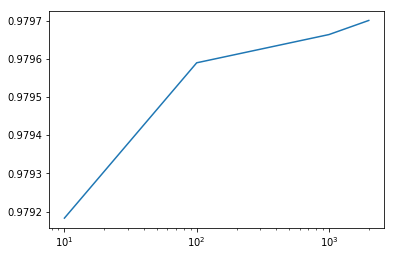

In [98]:
#plot validation curve for number of trees
plt.plot(n_estimators,test_nest_mean)
plt.xticks(n_estimators)
plt.xscale('log')

([<matplotlib.axis.XTick at 0x1a187e1490>,
 <a list of 4 Text xticklabel objects>)

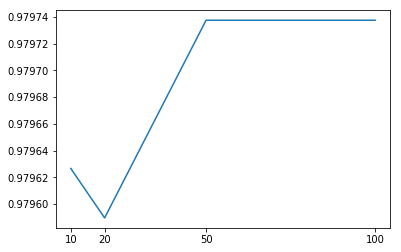

In [99]:
#plot validation curve for smaple split
plt.plot(min_samples_split,test_ss_mean)
plt.xticks(min_samples_split)

([<matplotlib.axis.XTick at 0x1a1735d6d0>,
 <a list of 3 Text xticklabel objects>)

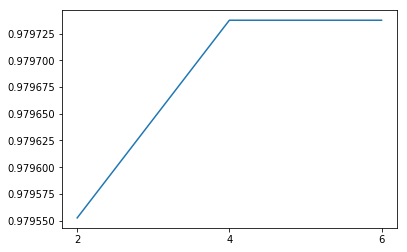

In [100]:
#plot validation curve for sample leaf
plt.plot(min_samples_leaf,test_sl_mean)
plt.xticks(min_samples_leaf)

In [101]:
#max_depthG=max_depth
#max_depthG[0]=0
#max_depthG
#plt.plot(max_depthG,test_maxd_mean)
#plt.xticks(max_depthG)

In [102]:
#run random forrest model with tuned parameters
rfc=RandomForestClassifier(random_state=10, n_estimators=100,min_samples_split=20,min_samples_leaf=4)
rfc.fit(Xtrain,ytrain)
print('Accuracy {}'.format(accuracy_score(rfc.predict(Xtest), ytest)))
print('Confusion Matrix {}'.format(confusion_matrix(rfc.predict(Xtest), ytest)))

Accuracy 0.978408754806
Confusion Matrix [[6616  146]
 [   0    0]]


In [103]:
#run untuned Gradient boosted classifier
gbc= GradientBoostingClassifier(random_state=10)
gbc.fit(Xtrain,ytrain)
print('Accuracy {}'.format(accuracy_score(gbc.predict(Xtest), ytest)))
print('Confusion Matrix {}'.format(confusion_matrix(gbc.predict(Xtest), ytest)))

Accuracy 0.977077787637
Confusion Matrix [[6607  146]
 [   9    0]]


In [104]:
#tune gbc with validation curves
n_estimators= [5, 10, 50]
learning_rate= [.05,.1,.25]
min_samples_split=[ 100, 200, 500, 1000]
min_samples_leaf=[  10, 20, 30]
gbc= GradientBoostingClassifier(random_state=10)
print('begin')
gbctrain_nest, gbctest_nest=validation_curve(gbc, X, y, param_name='n_estimators', 
                                   param_range=n_estimators, scoring='accuracy', cv=5 )
print('done nest')
gbctrain_ss, gbctest_ss=validation_curve(gbc, X, y, param_name='min_samples_split', 
                                   param_range=min_samples_split, scoring='accuracy', cv=5 )
print('done ss')
gbctrain_sl, gbctest_sl=validation_curve(gbc, X, y, param_name='min_samples_leaf', 
                                   param_range=min_samples_leaf, scoring='accuracy', cv=5 )
print('done sl')
gbctrain_lr, gbctest_lr=validation_curve(gbc, X, y, param_name='learning_rate', 
                                   param_range=learning_rate, scoring='accuracy', cv=5 )
print('done lr')
print('done')


begin
done nest
done ss
done sl
done


In [105]:
#find the means for the different scores with each parameter
gbctrain_nest_mean=np.mean(gbctrain_nest, axis=1)
gbctrain_ss_mean=np.mean(gbctrain_ss, axis=1)
gbctrain_sl_mean=np.mean(gbctrain_sl, axis=1)
gbctrain_lr_mean=np.mean(gbctrain_lr, axis=1)

gbctest_nest_mean=np.mean(gbctest_nest, axis=1)
gbctest_ss_mean=np.mean(gbctest_ss, axis=1)
gbctest_sl_mean=np.mean(gbctest_sl, axis=1)
gbctest_lr_mean=np.mean(gbctest_lr, axis=1)

([<matplotlib.axis.XTick at 0x1a17ffe210>,
 <a list of 3 Text xticklabel objects>)

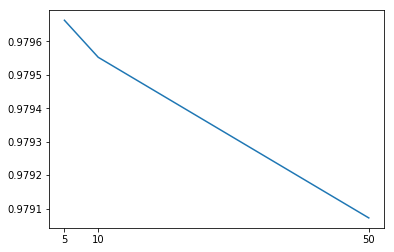

In [106]:
#plot validation curve for number of trees
plt.plot(n_estimators,gbctest_nest_mean)
plt.xticks(n_estimators)

([<matplotlib.axis.XTick at 0x1a1a0e0850>,
 <a list of 4 Text xticklabel objects>)

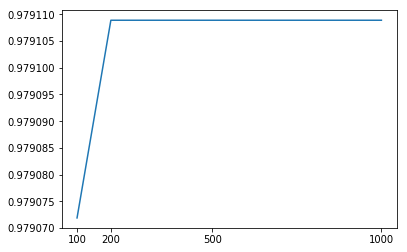

In [107]:
#plot validation curve for smaple split
plt.plot(min_samples_split,gbctest_ss_mean)
plt.xticks(min_samples_split)

([<matplotlib.axis.XTick at 0x1a198fb090>,
 <a list of 3 Text xticklabel objects>)

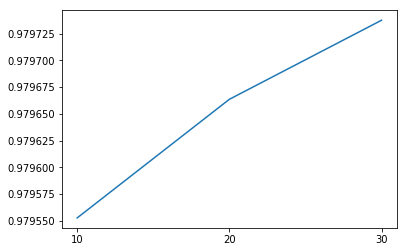

In [108]:
#plot validation curve for sample leaf
plt.plot(min_samples_leaf,gbctest_sl_mean)
plt.xticks(min_samples_leaf)

([<matplotlib.axis.XTick at 0x1a1a03e250>,
 <a list of 3 Text xticklabel objects>)

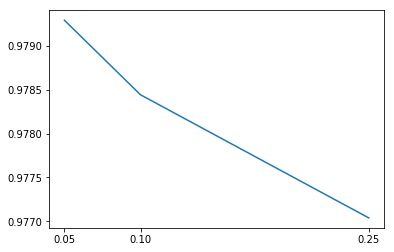

In [109]:
#plot validation curve for learning rate
plt.plot(learning_rate,gbctest_lr_mean)
plt.xticks(learning_rate)

In [22]:
#run tuned classifier
gbc= GradientBoostingClassifier(random_state=10, n_estimators=10, learning_rate=.05, 
                                min_samples_split=1000,min_samples_leaf=20,  )
gbc.fit(Xtrain,ytrain)
print('Accuracy {}'.format(accuracy_score(gbc.predict(Xtest), ytest)))
print('Confusion Matrix {}'.format(confusion_matrix(gbc.predict(Xtest), ytest)))

Accuracy 0.978408754806
Confusion Matrix [[6616  146]
 [   0    0]]


In [24]:
sdg=SGDClassifier(random_state=100)
sdg.fit(Xtrain,ytrain)
print('Accuracy {}'.format(accuracy_score(sdg.predict(Xtest), ytest)))
print('Confusion Matrix {}'.format(confusion_matrix(sdg.predict(Xtest), ytest)))

Accuracy 0.978408754806
Confusion Matrix [[6616  146]
 [   0    0]]


In [9]:
#tune gbc with validation curves
loss= ['hinge', 'log']
max_iter= [5,10,50, 100]

n_iter_no_change=[ 5, 10, 20, 30]
sdg=SGDClassifier(random_state=10)
print('begin')
sdgtrain_loss, sdgtest_loss=validation_curve(sdg, X, y, param_name='loss', 
                                   param_range=loss, scoring='accuracy', cv=5 )
print('done loss')
sdgtrain_mi, sdgtest_mi=validation_curve(sdg, X, y, param_name='max_iter', 
                                   param_range=max_iter, scoring='accuracy', cv=5 )
print('done max_iter')
sdgtrain_ninc, sdgtest_ninc=validation_curve(sdg, X, y, param_name='n_iter_no_change', 
                                   param_range=n_iter_no_change, scoring='accuracy', cv=5 )
print('done n_iter_no_change')

print('done')


begin
done nest
done ss
done sl
done


In [10]:
#find the means for the different scores with each parameter
sdgtrain_loss_mean=np.mean(sdgtrain_loss, axis=1)
sdgtrain_mi_mean=np.mean(sdgtrain_mi, axis=1)
sdgtrain_ninc_mean=np.mean(sdgtrain_ninc, axis=1)


sdgtest_loss_mean=np.mean(sdgtest_loss, axis=1)
sdgtest_mi_mean=np.mean(sdgtest_mi, axis=1)
sdgtest_ninc_mean=np.mean(sdgtest_ninc, axis=1)


([<matplotlib.axis.XTick at 0x1a25ac5310>,
 <a list of 2 Text xticklabel objects>)

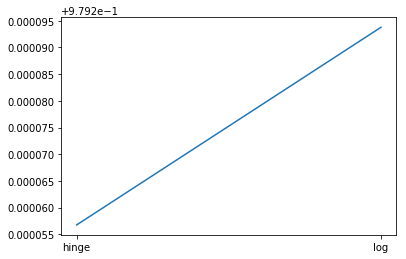

In [37]:
#plot validation curve for the loss function
plt.plot(loss,sdgtest_loss_mean)
plt.xticks(loss)

([<matplotlib.axis.XTick at 0x1a251bf590>,
 <a list of 4 Text xticklabel objects>)

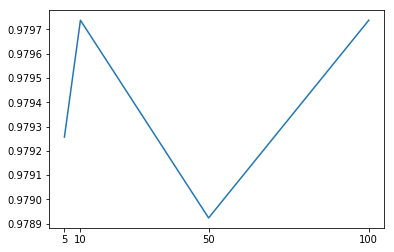

In [38]:
#plot validation curve for max_iter
plt.plot(max_iter,sdgtest_mi_mean)
plt.xticks(max_iter)

([<matplotlib.axis.XTick at 0x1a25b5b210>,
 <a list of 4 Text xticklabel objects>)

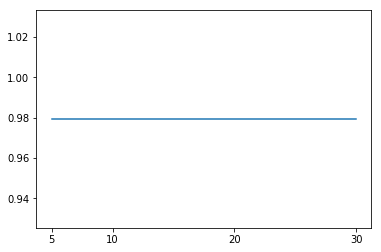

In [39]:
#plot validation curve for the loss function
plt.plot(n_iter_no_change,sdgtest_ninc_mean)
plt.xticks(n_iter_no_change)

In [41]:
#run the tuned model
sdg=SGDClassifier(random_state=100, max_iter=100, loss='log')
sdg.fit(Xtrain,ytrain)
print('Accuracy {}'.format(accuracy_score(sdg.predict(Xtest), ytest)))
print('Confusion Matrix {}'.format(confusion_matrix(sdg.predict(Xtest), ytest)))

Accuracy 0.978408754806
Confusion Matrix [[6616  146]
 [   0    0]]
